In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

#contour = load_contour().to(device)
#contour.shape

In [2]:
T = 100
beta = torch.linspace(900e-4, 500e-4, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0007, device='cuda:0')

In [3]:
alpha_

tensor([9.1000e-01, 8.2847e-01, 7.5458e-01, 6.8758e-01, 6.2681e-01, 5.7166e-01,
        5.2160e-01, 4.7613e-01, 4.3482e-01, 3.9726e-01, 3.6312e-01, 3.3205e-01,
        3.0377e-01, 2.7803e-01, 2.5458e-01, 2.3321e-01, 2.1373e-01, 1.9596e-01,
        1.7975e-01, 1.6495e-01, 1.5144e-01, 1.3910e-01, 1.2781e-01, 1.1750e-01,
        1.0806e-01, 9.9428e-02, 9.1524e-02, 8.4285e-02, 7.7653e-02, 7.1574e-02,
        6.6000e-02, 6.0887e-02, 5.6194e-02, 5.1886e-02, 4.7929e-02, 4.4293e-02,
        4.0951e-02, 3.7878e-02, 3.5050e-02, 3.2448e-02, 3.0052e-02, 2.7845e-02,
        2.5812e-02, 2.3937e-02, 2.2208e-02, 2.0613e-02, 1.9141e-02, 1.7782e-02,
        1.6527e-02, 1.5366e-02, 1.4294e-02, 1.3302e-02, 1.2384e-02, 1.1535e-02,
        1.0748e-02, 1.0020e-02, 9.3448e-03, 8.7190e-03, 8.1386e-03, 7.6001e-03,
        7.1004e-03, 6.6363e-03, 6.2053e-03, 5.8048e-03, 5.4324e-03, 5.0862e-03,
        4.7641e-03, 4.4643e-03, 4.1851e-03, 3.9252e-03, 3.6829e-03, 3.4571e-03,
        3.2465e-03, 3.0501e-03, 2.8668e-

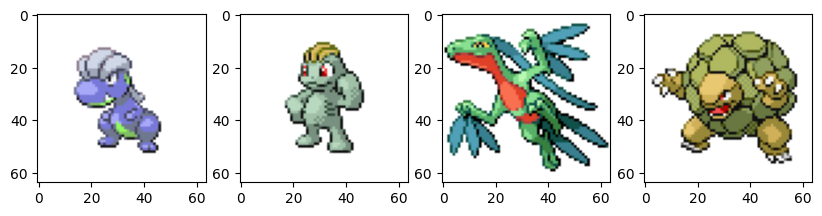

In [4]:
transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [6]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 64, 64), device=device)
    h = torch.tensor([0.2, 0.5, 1.0], device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, h) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|                                                                                                                                       | 0/100001 [00:00<?, ?it/s]

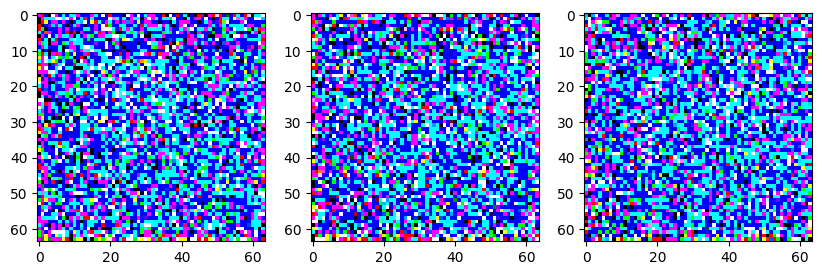

0.06341775:   1%|█                                                                                                              | 999/100001 [01:26<2:20:42, 11.73it/s]

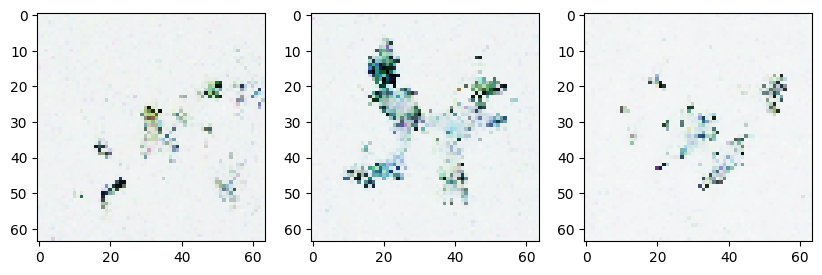

0.03224274:   2%|██▏                                                                                                           | 1999/100001 [02:53<2:19:09, 11.74it/s]

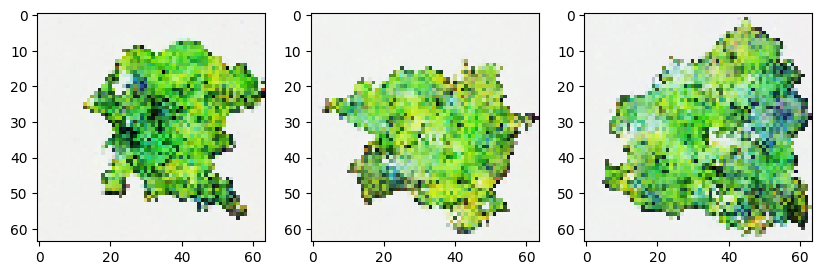

0.05400245:   3%|███▎                                                                                                          | 2999/100001 [04:20<2:17:28, 11.76it/s]

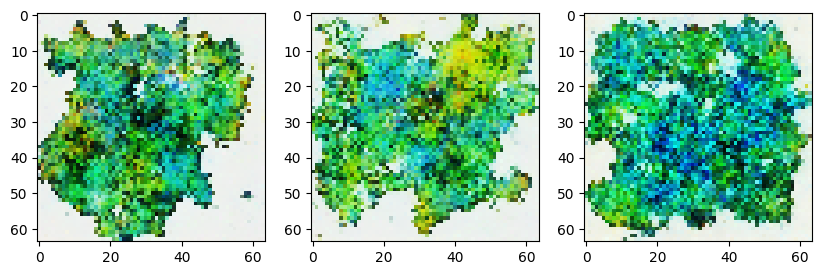

0.03281526:   4%|████▍                                                                                                         | 3999/100001 [05:46<2:16:20, 11.74it/s]

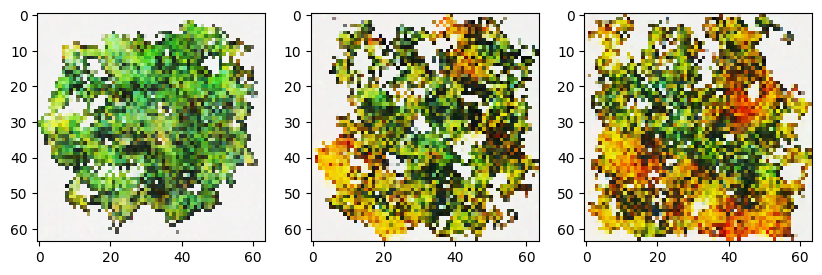

0.02082936:   5%|█████▍                                                                                                        | 4999/100001 [07:13<2:14:45, 11.75it/s]

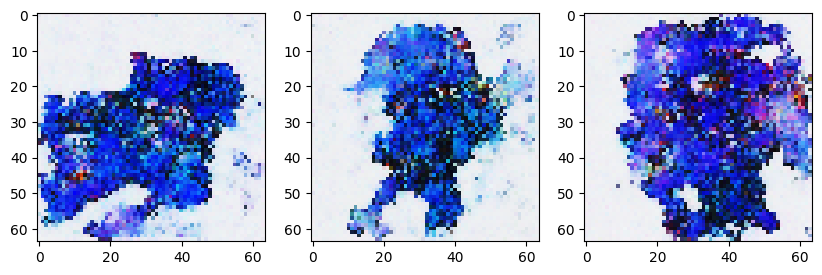

0.03016795:   6%|██████▌                                                                                                       | 5999/100001 [08:39<2:13:22, 11.75it/s]

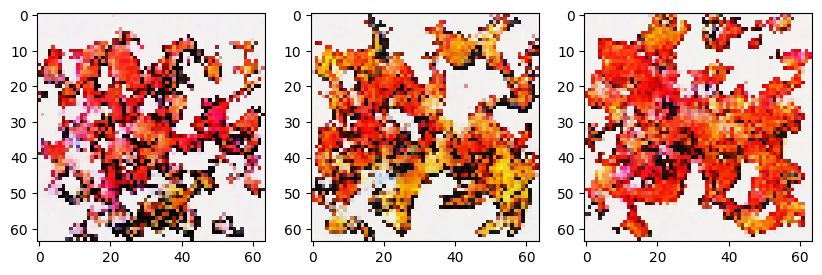

0.01122582:   7%|███████▋                                                                                                      | 6999/100001 [10:06<2:12:05, 11.73it/s]

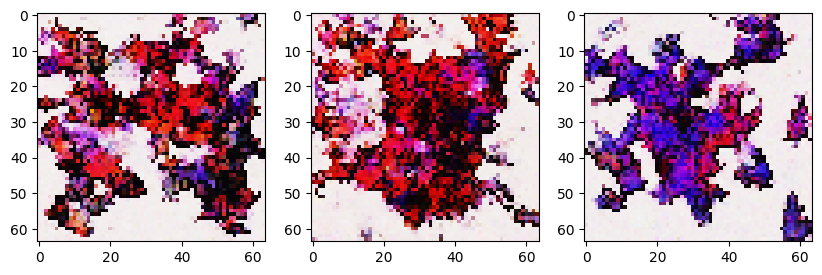

0.02831017:   8%|████████▊                                                                                                     | 7999/100001 [11:33<2:10:31, 11.75it/s]

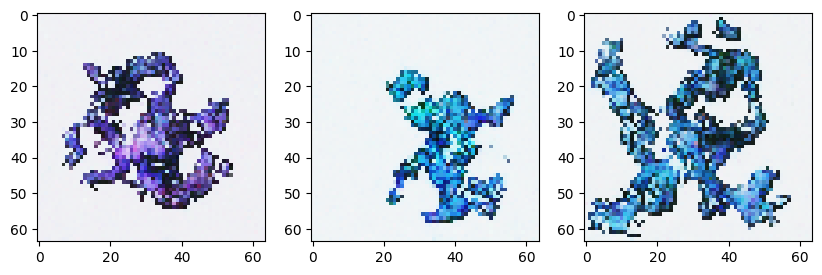

0.01752550:   9%|█████████▉                                                                                                    | 8999/100001 [12:59<2:09:08, 11.74it/s]

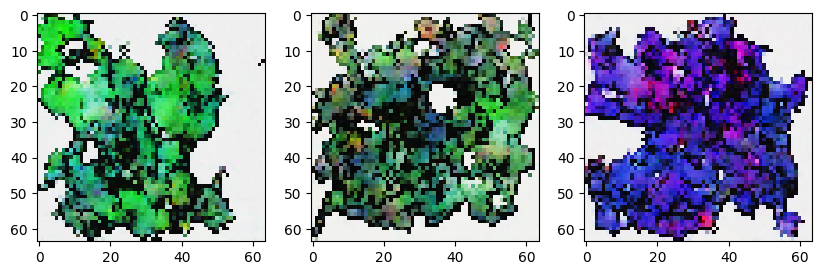

0.02314213:  10%|██████████▉                                                                                                   | 9999/100001 [14:26<2:07:39, 11.75it/s]

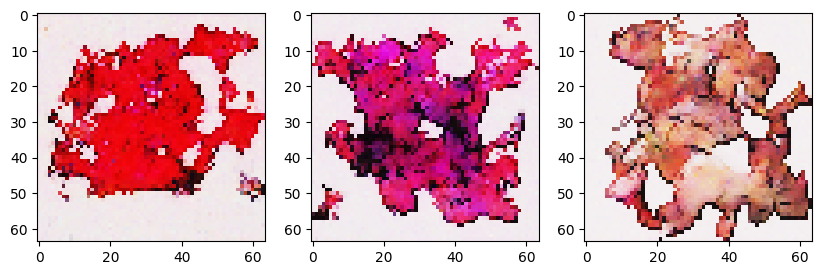

0.01684067:  11%|███████████▉                                                                                                 | 10999/100001 [15:53<2:06:14, 11.75it/s]

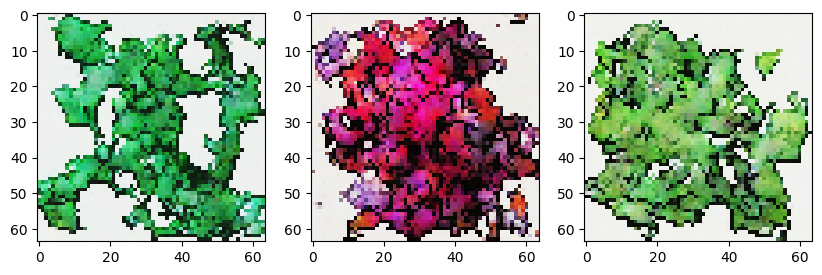

0.02148403:  12%|█████████████                                                                                                | 11999/100001 [17:19<2:04:58, 11.74it/s]

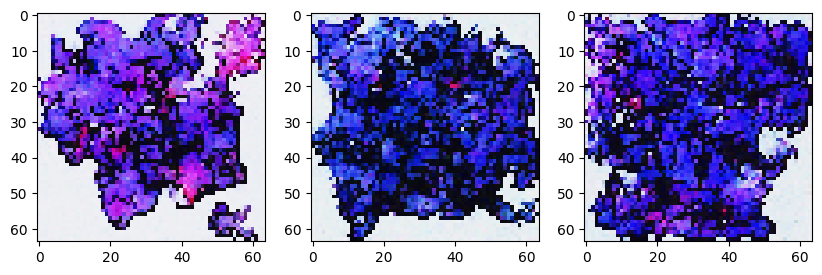

0.01910350:  13%|██████████████▏                                                                                              | 12999/100001 [18:46<2:03:33, 11.74it/s]

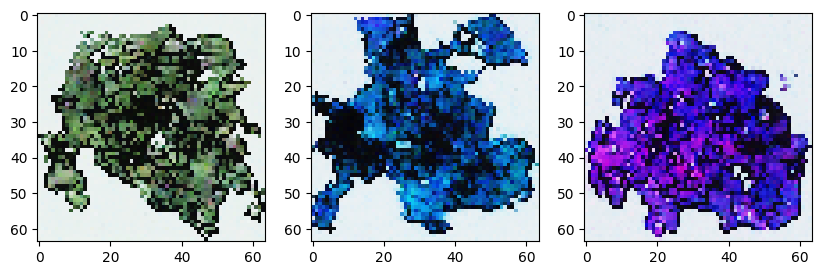

0.02983924:  14%|███████████████▎                                                                                             | 13999/100001 [20:13<2:02:26, 11.71it/s]

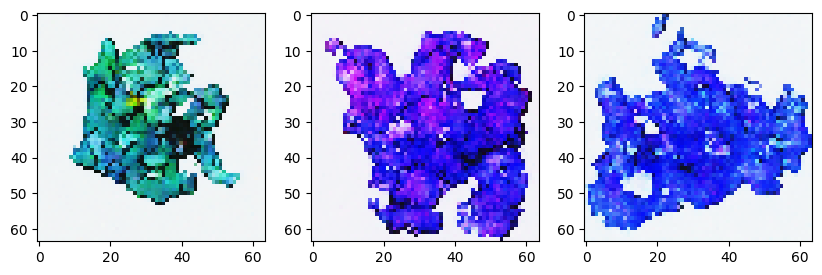

0.02112608:  15%|████████████████▎                                                                                            | 14999/100001 [21:39<2:00:37, 11.75it/s]

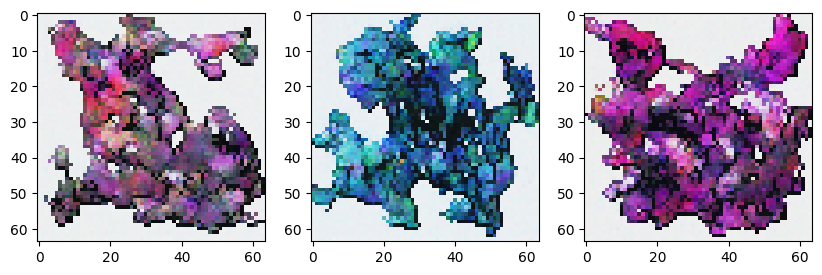

0.01360432:  16%|█████████████████▍                                                                                           | 15999/100001 [23:06<1:59:07, 11.75it/s]

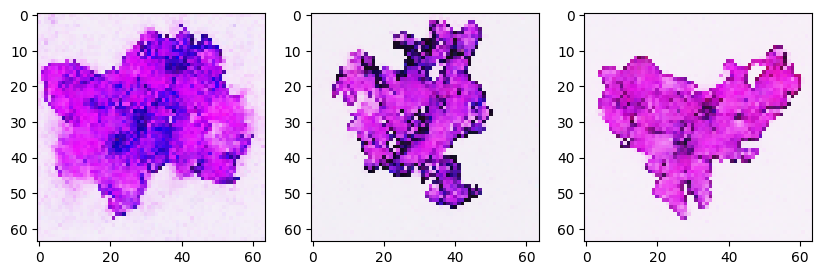

0.03852090:  17%|██████████████████▌                                                                                          | 16999/100001 [24:33<1:57:53, 11.74it/s]

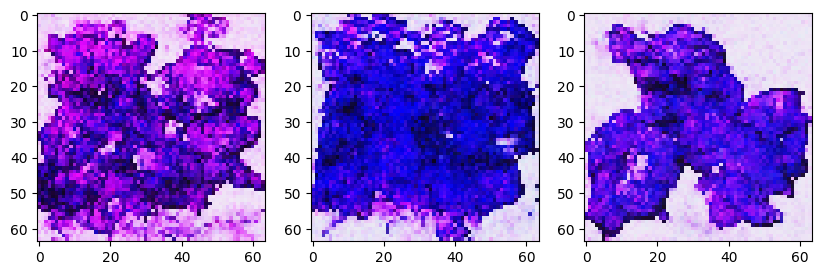

0.01103115:  18%|███████████████████▌                                                                                         | 17999/100001 [25:59<1:56:34, 11.72it/s]

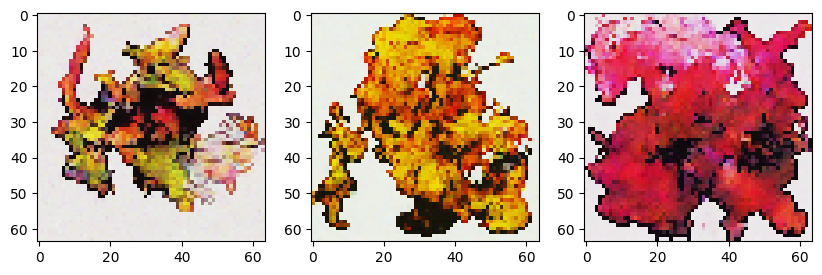

0.01615396:  19%|████████████████████▋                                                                                        | 18999/100001 [27:26<1:55:02, 11.73it/s]

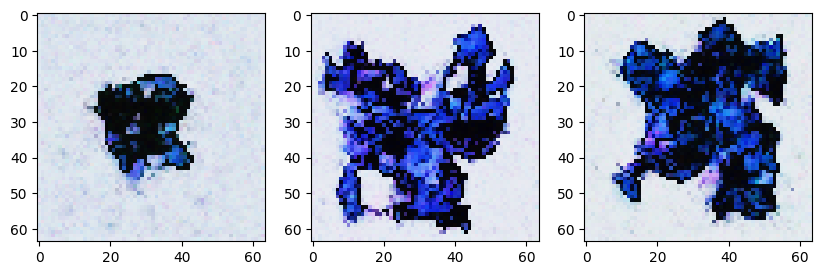

0.02896585:  20%|█████████████████████▊                                                                                       | 19999/100001 [28:53<1:53:34, 11.74it/s]

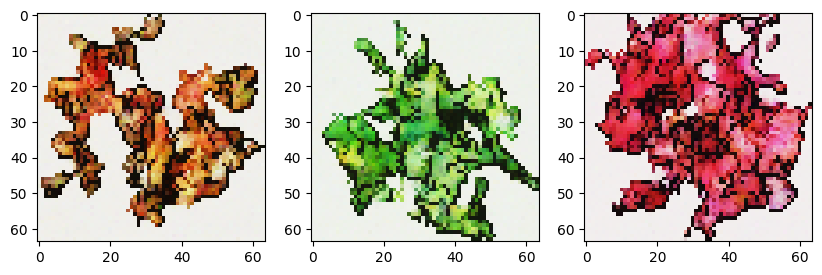

0.02382956:  21%|██████████████████████▉                                                                                      | 20999/100001 [30:19<1:52:06, 11.75it/s]

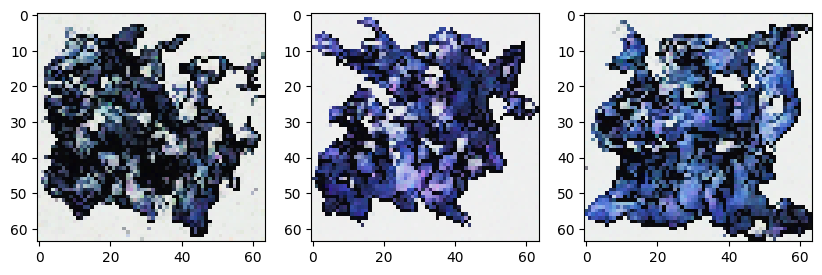

0.01055932:  22%|███████████████████████▉                                                                                     | 21999/100001 [31:46<1:50:41, 11.74it/s]

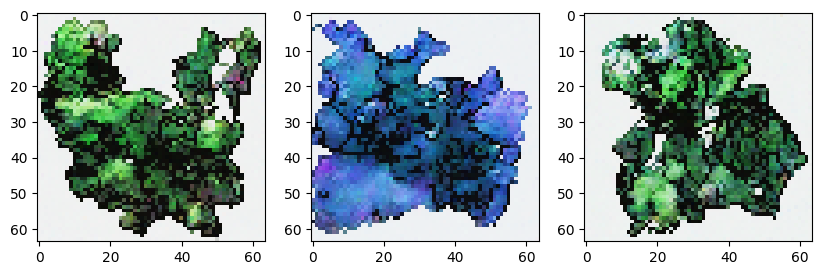

0.01338331:  23%|█████████████████████████                                                                                    | 22999/100001 [33:13<1:49:24, 11.73it/s]

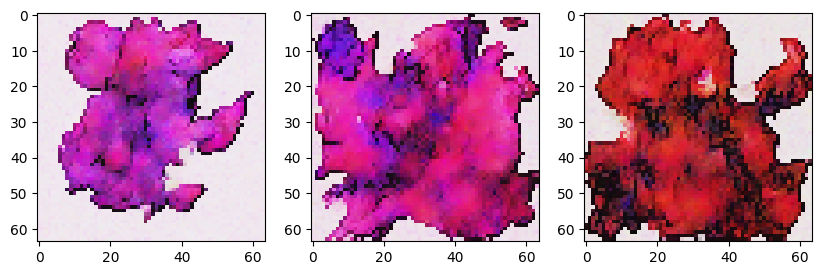

0.02003954:  24%|██████████████████████████▏                                                                                  | 23999/100001 [34:39<1:48:01, 11.73it/s]

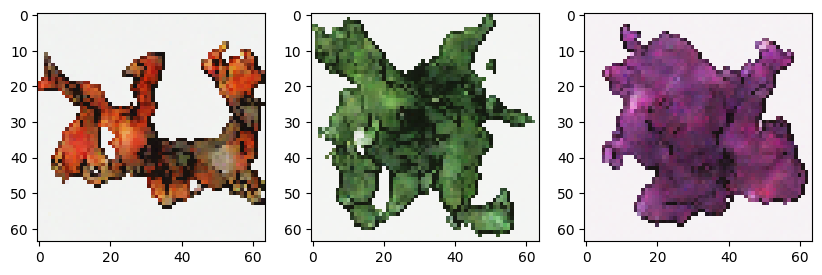

0.03827695:  25%|███████████████████████████▏                                                                                 | 24999/100001 [36:06<1:46:34, 11.73it/s]

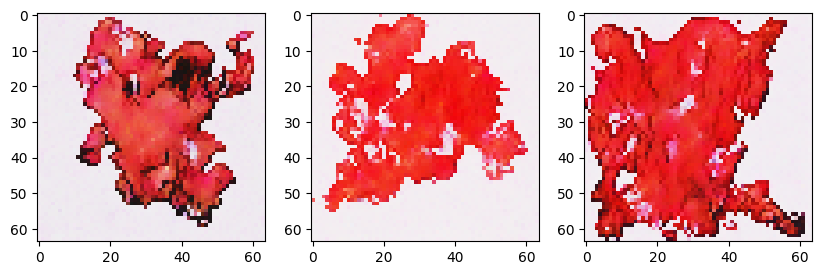

0.02452005:  26%|████████████████████████████▎                                                                                | 25999/100001 [37:33<1:45:06, 11.73it/s]

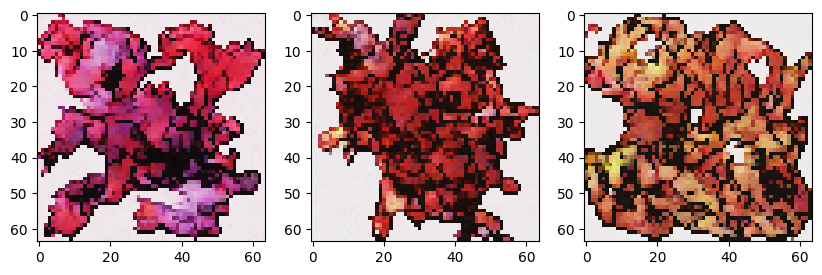

0.01564084:  27%|█████████████████████████████▍                                                                               | 26999/100001 [38:59<1:43:47, 11.72it/s]

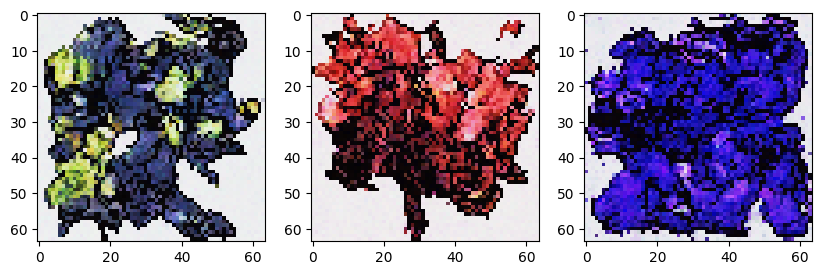

0.01423839:  28%|██████████████████████████████▌                                                                              | 27999/100001 [40:26<1:42:24, 11.72it/s]

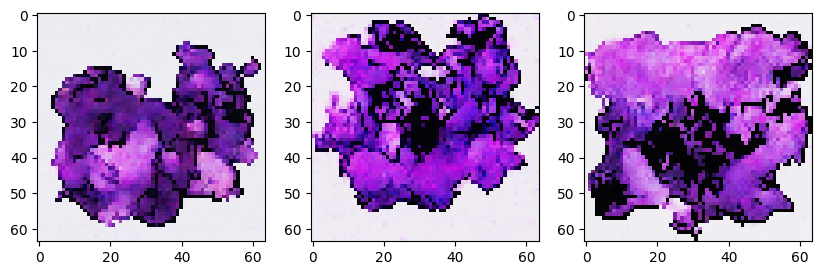

0.01403745:  29%|███████████████████████████████▌                                                                             | 28999/100001 [41:53<1:40:59, 11.72it/s]

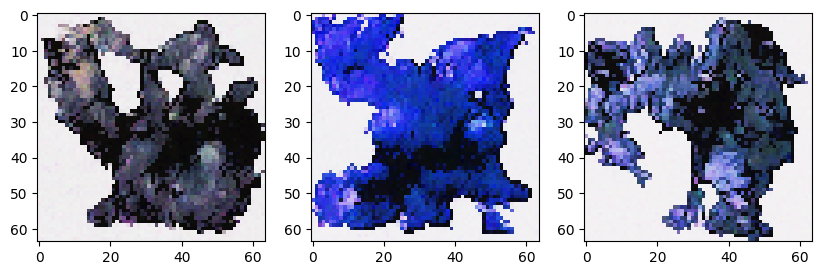

0.00725706:  30%|████████████████████████████████▋                                                                            | 29999/100001 [43:20<1:39:30, 11.72it/s]

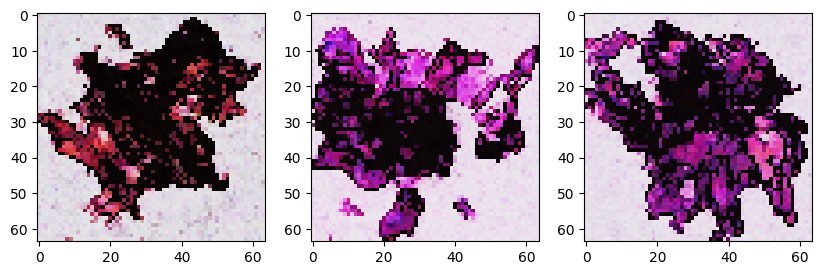

0.03414492:  31%|█████████████████████████████████▊                                                                           | 30999/100001 [44:46<1:38:02, 11.73it/s]

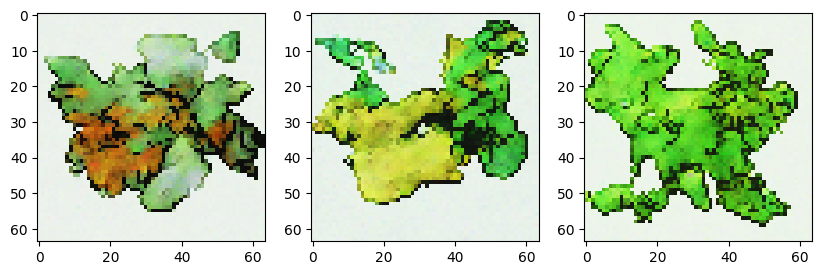

0.03159941:  32%|██████████████████████████████████▉                                                                          | 31999/100001 [46:13<1:36:33, 11.74it/s]

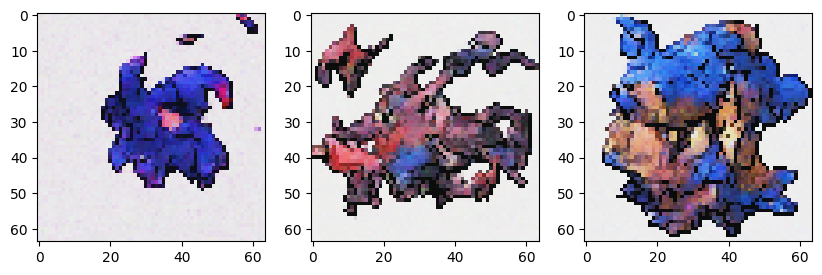

0.01598877:  33%|███████████████████████████████████▉                                                                         | 32999/100001 [47:40<1:35:09, 11.74it/s]

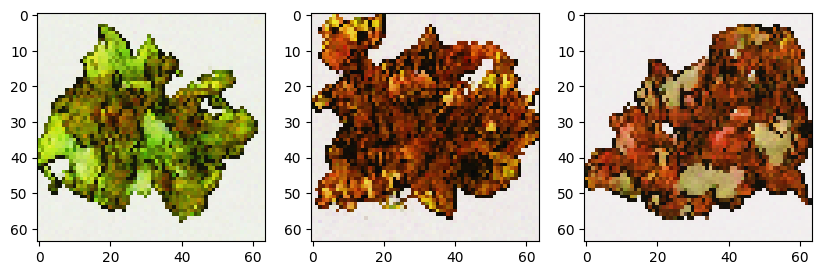

0.02721067:  34%|█████████████████████████████████████                                                                        | 33999/100001 [49:06<1:33:42, 11.74it/s]

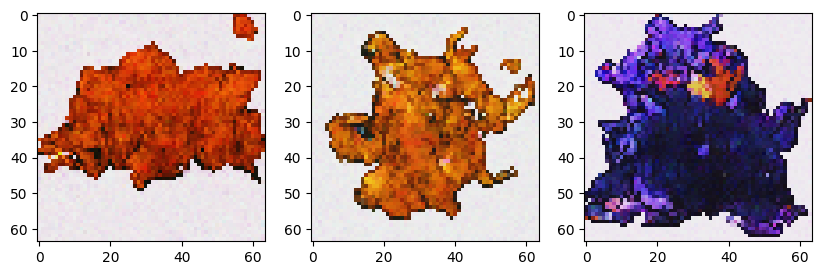

0.02151687:  35%|██████████████████████████████████████▏                                                                      | 34999/100001 [50:33<1:32:17, 11.74it/s]

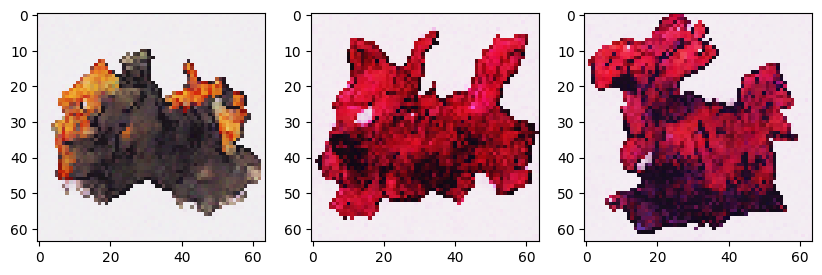

0.02457595:  36%|███████████████████████████████████████▏                                                                     | 35999/100001 [52:00<1:30:55, 11.73it/s]

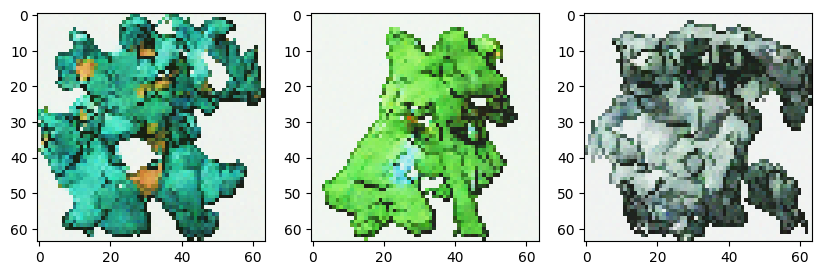

0.01907899:  37%|████████████████████████████████████████▎                                                                    | 36999/100001 [53:27<1:29:28, 11.74it/s]

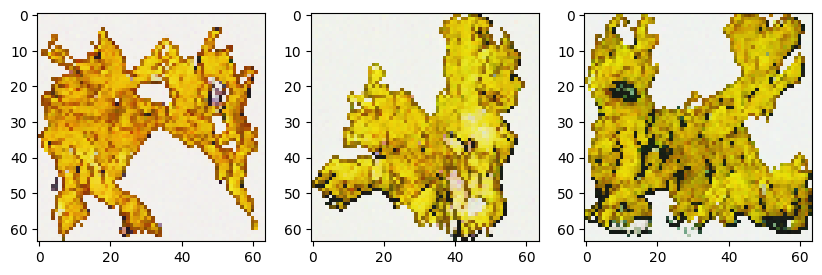

0.01740446:  38%|█████████████████████████████████████████▍                                                                   | 37999/100001 [54:53<1:28:03, 11.74it/s]

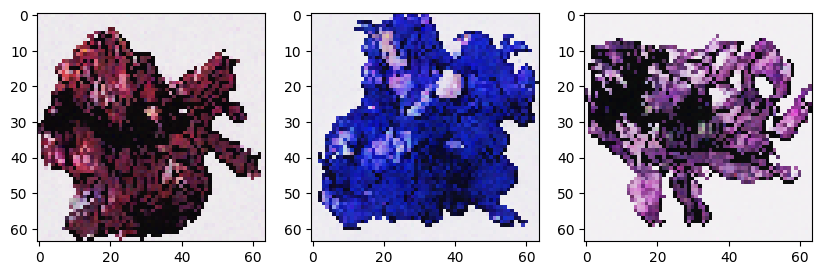

0.01410675:  39%|██████████████████████████████████████████▌                                                                  | 38999/100001 [56:20<1:26:41, 11.73it/s]

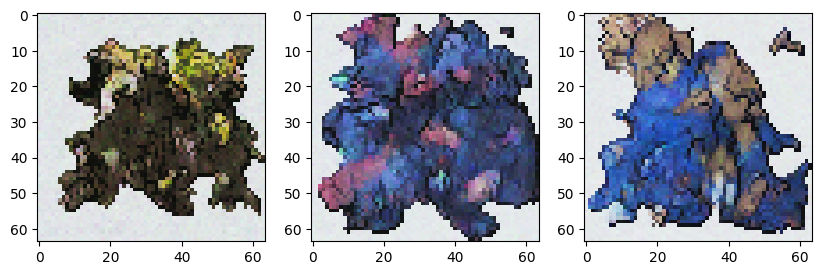

0.01285094:  40%|███████████████████████████████████████████▌                                                                 | 39999/100001 [57:47<1:25:12, 11.74it/s]

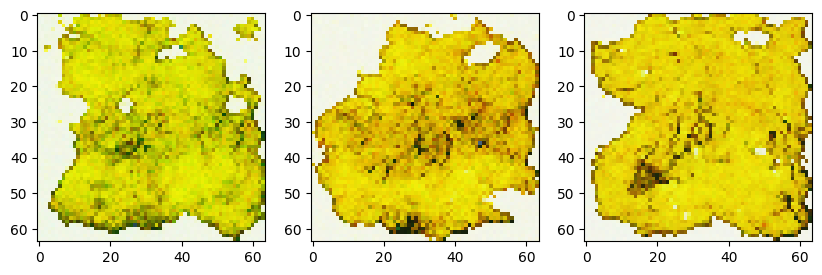

0.01959212:  41%|████████████████████████████████████████████▋                                                                | 40999/100001 [59:13<1:23:42, 11.75it/s]

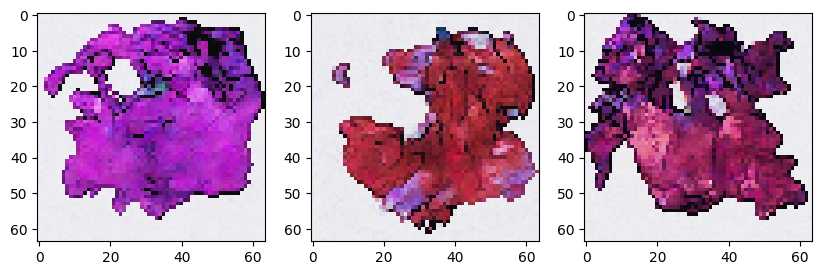

0.01868615:  42%|████████████████████████████████████████████▉                                                              | 41999/100001 [1:00:40<1:22:22, 11.73it/s]

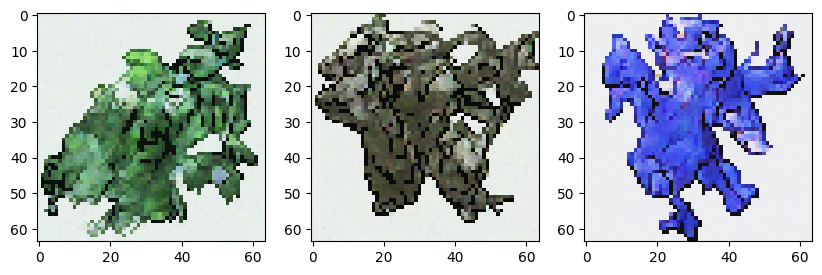

0.03066479:  43%|██████████████████████████████████████████████                                                             | 42999/100001 [1:02:07<1:21:02, 11.72it/s]

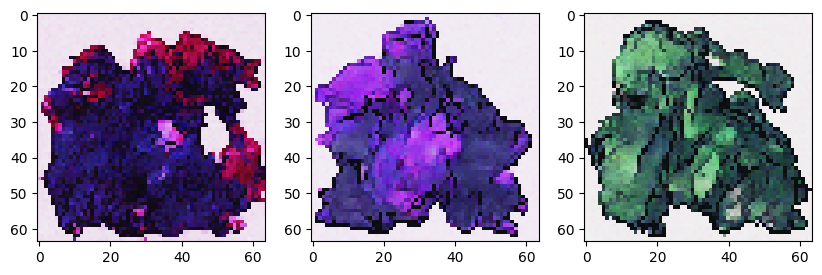

0.02763814:  44%|███████████████████████████████████████████████                                                            | 43999/100001 [1:03:33<1:19:27, 11.75it/s]

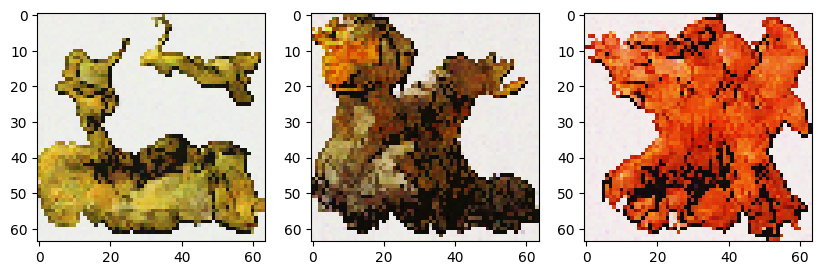

0.02278658:  45%|████████████████████████████████████████████████▏                                                          | 44999/100001 [1:05:00<1:18:07, 11.73it/s]

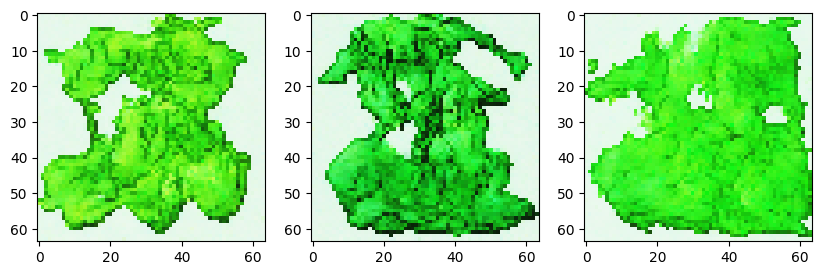

0.01402161:  46%|█████████████████████████████████████████████████▏                                                         | 45999/100001 [1:06:27<1:16:38, 11.74it/s]

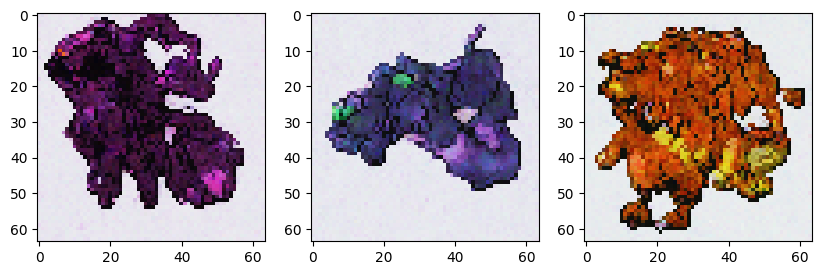

0.01536672:  47%|██████████████████████████████████████████████████▎                                                        | 46999/100001 [1:07:53<1:15:20, 11.72it/s]

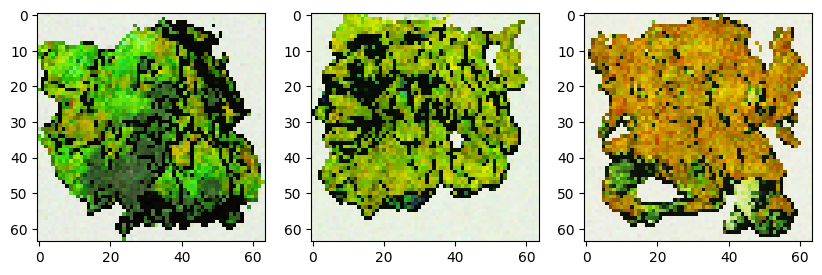

0.02641789:  48%|███████████████████████████████████████████████████▎                                                       | 47999/100001 [1:09:20<1:13:52, 11.73it/s]

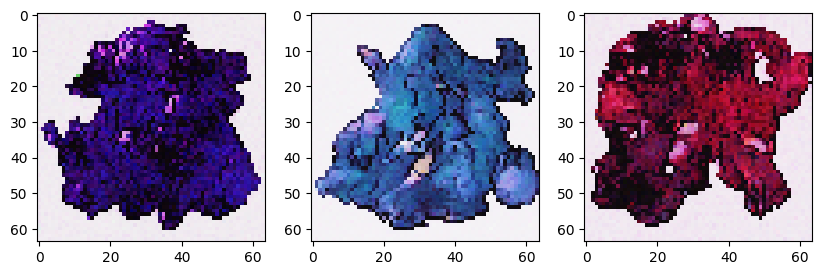

0.01557973:  49%|████████████████████████████████████████████████████▍                                                      | 48999/100001 [1:10:47<1:12:25, 11.74it/s]

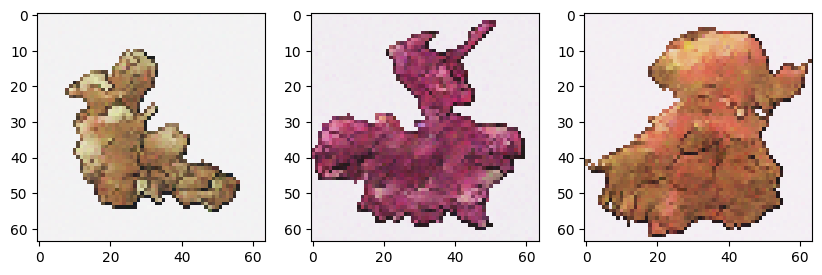

0.03256452:  50%|█████████████████████████████████████████████████████▍                                                     | 49999/100001 [1:12:13<1:11:04, 11.72it/s]

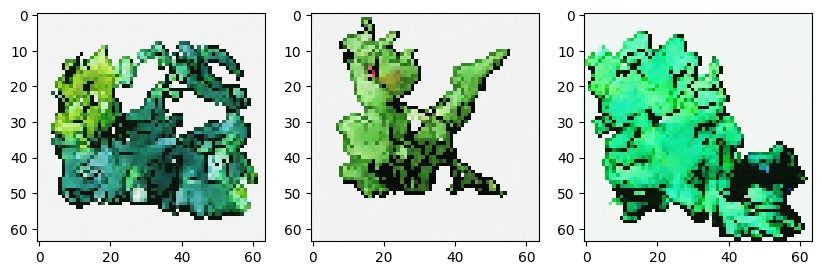

0.02826145:  51%|██████████████████████████████████████████████████████▌                                                    | 50999/100001 [1:13:40<1:09:37, 11.73it/s]

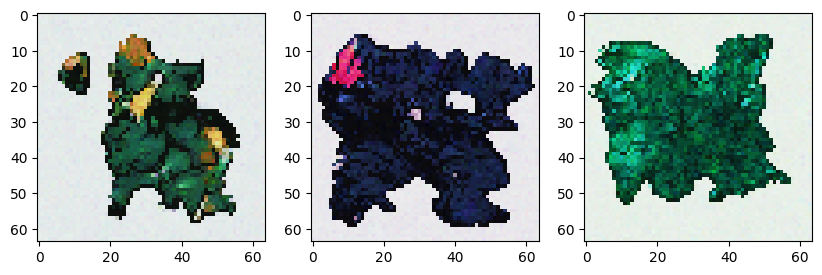

0.02310791:  52%|███████████████████████████████████████████████████████▋                                                   | 51999/100001 [1:15:07<1:08:10, 11.73it/s]

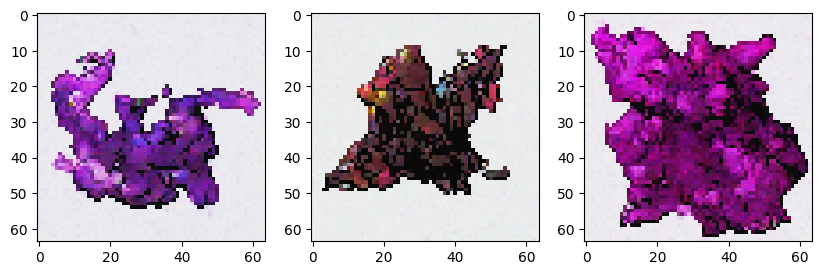

0.02021278:  53%|████████████████████████████████████████████████████████▋                                                  | 52999/100001 [1:16:34<1:06:46, 11.73it/s]

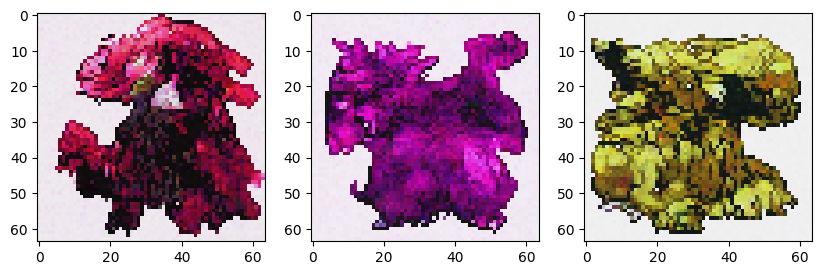

0.01187200:  54%|█████████████████████████████████████████████████████████▊                                                 | 53999/100001 [1:18:00<1:05:22, 11.73it/s]

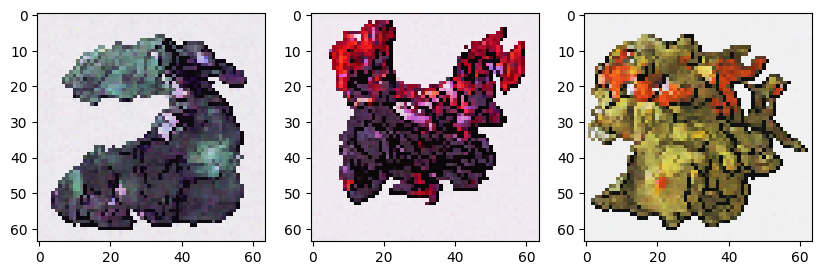

0.02645786:  55%|██████████████████████████████████████████████████████████▊                                                | 54999/100001 [1:19:27<1:03:53, 11.74it/s]

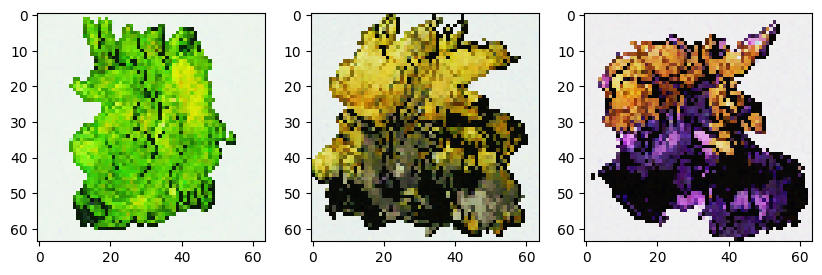

0.01932501:  56%|███████████████████████████████████████████████████████████▉                                               | 55999/100001 [1:20:54<1:02:36, 11.71it/s]

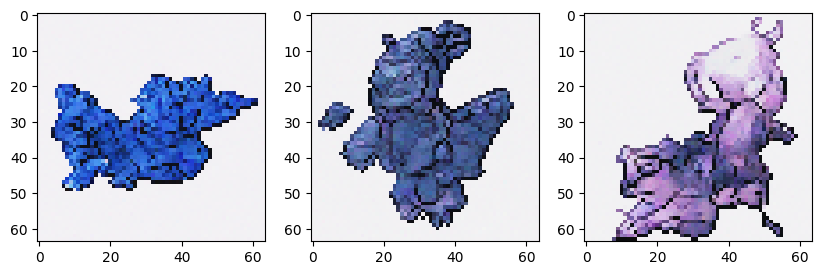

0.01456416:  57%|████████████████████████████████████████████████████████████▉                                              | 56999/100001 [1:22:20<1:01:02, 11.74it/s]

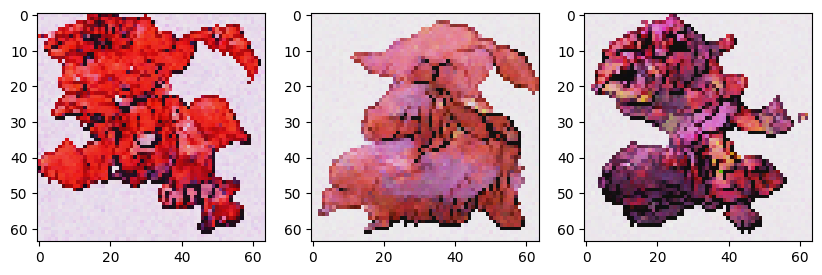

0.02054460:  58%|███████████████████████████████████████████████████████████████▏                                             | 57999/100001 [1:23:47<59:34, 11.75it/s]

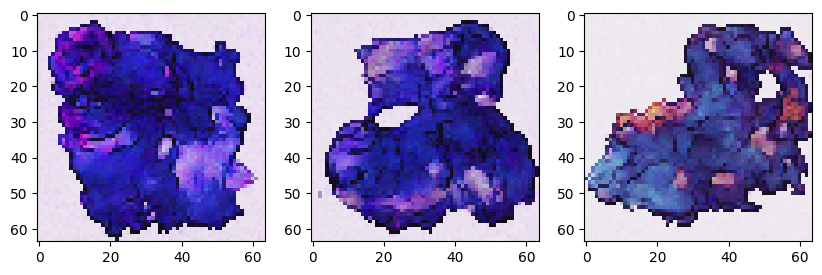

0.02096420:  59%|████████████████████████████████████████████████████████████████▎                                            | 58999/100001 [1:25:14<58:21, 11.71it/s]

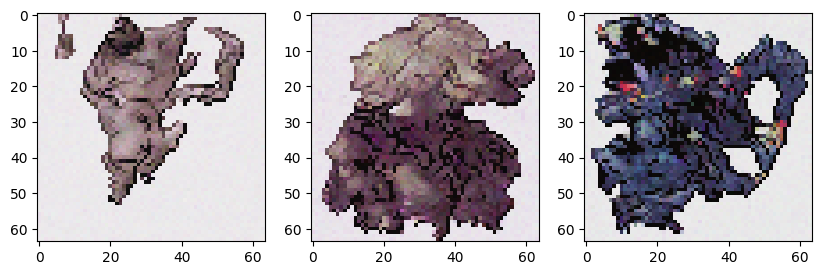

0.01696164:  60%|█████████████████████████████████████████████████████████████████▍                                           | 59999/100001 [1:26:40<56:43, 11.75it/s]

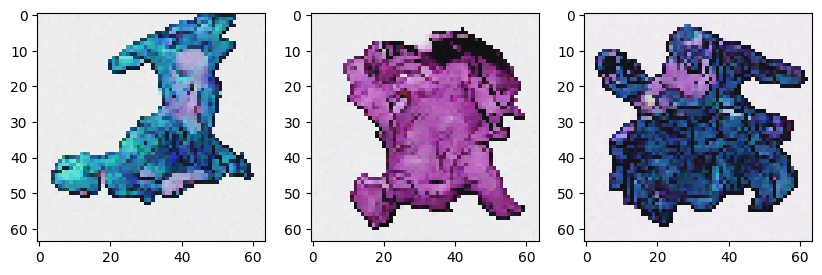

0.01144077:  61%|██████████████████████████████████████████████████████████████████▍                                          | 60999/100001 [1:28:07<55:23, 11.74it/s]

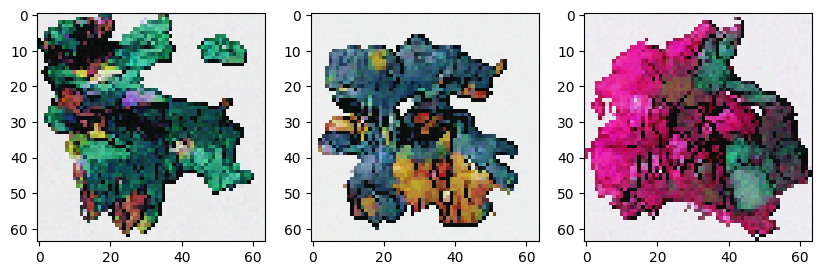

0.01741089:  62%|███████████████████████████████████████████████████████████████████▌                                         | 61999/100001 [1:29:34<53:56, 11.74it/s]

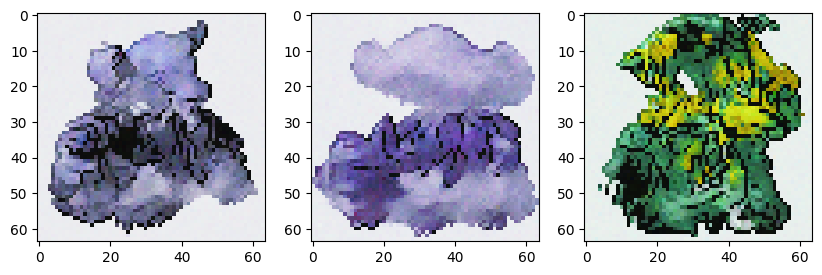

0.03584617:  63%|████████████████████████████████████████████████████████████████████▋                                        | 62999/100001 [1:31:00<52:34, 11.73it/s]

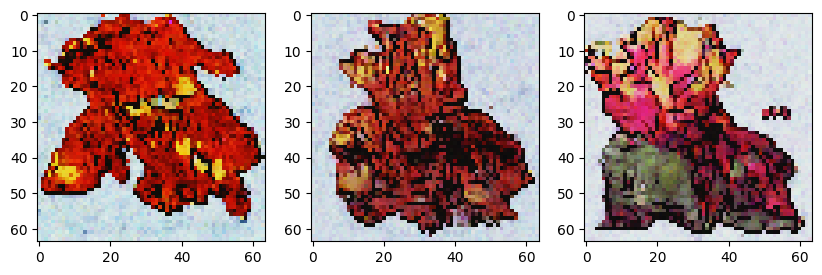

0.01630225:  64%|█████████████████████████████████████████████████████████████████████▊                                       | 63999/100001 [1:32:27<51:09, 11.73it/s]

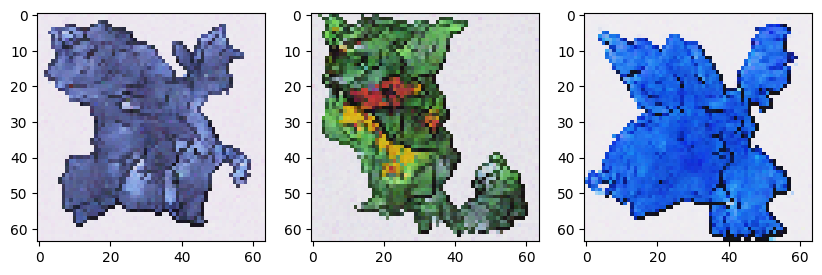

0.01916066:  65%|██████████████████████████████████████████████████████████████████████▊                                      | 64999/100001 [1:33:54<49:53, 11.69it/s]

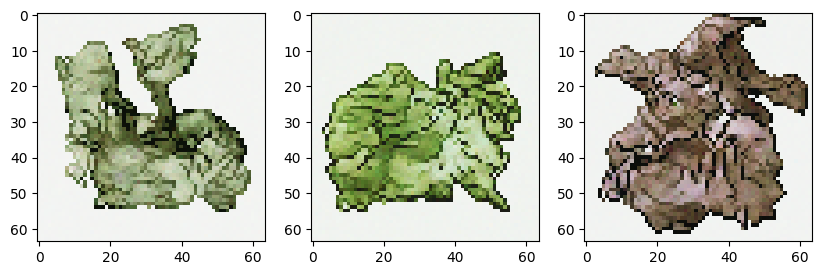

0.01707801:  66%|███████████████████████████████████████████████████████████████████████▉                                     | 65999/100001 [1:35:21<48:20, 11.72it/s]

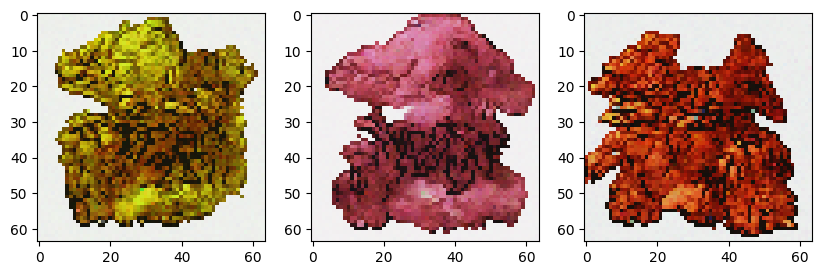

0.01618393:  67%|█████████████████████████████████████████████████████████████████████████                                    | 66999/100001 [1:36:47<46:54, 11.73it/s]

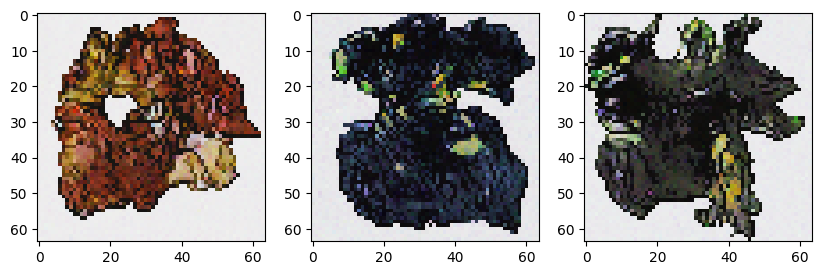

0.00946497:  68%|██████████████████████████████████████████████████████████████████████████                                   | 67999/100001 [1:38:14<45:30, 11.72it/s]

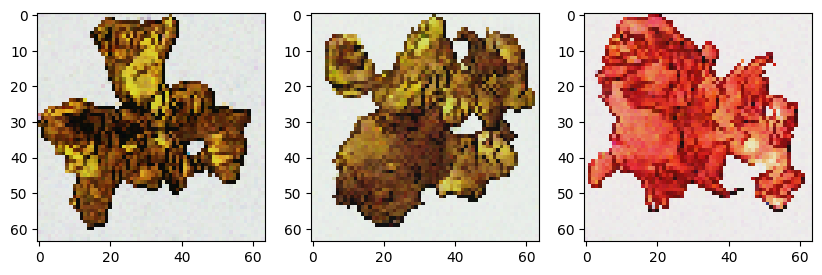

0.01653031:  69%|███████████████████████████████████████████████████████████████████████████▏                                 | 68999/100001 [1:39:41<44:03, 11.73it/s]

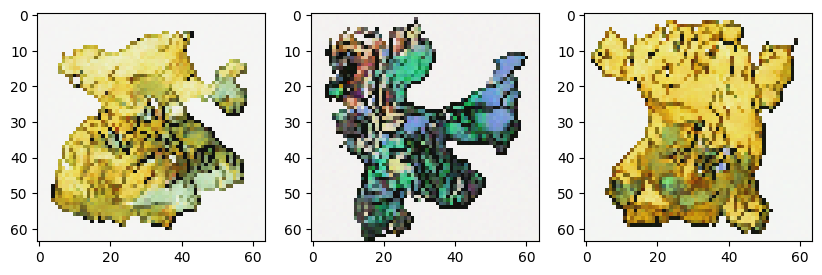

0.00963730:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 69999/100001 [1:41:07<42:36, 11.74it/s]

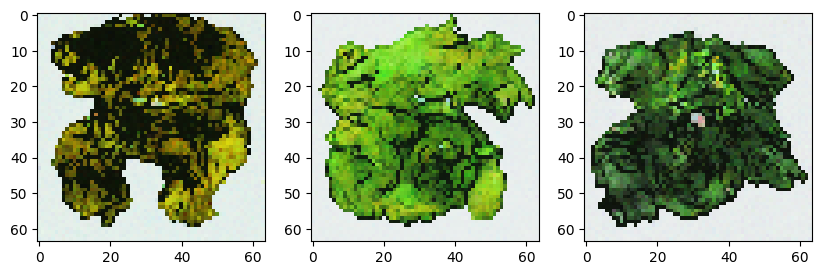

0.01381842:  71%|█████████████████████████████████████████████████████████████████████████████▍                               | 70999/100001 [1:42:34<41:12, 11.73it/s]

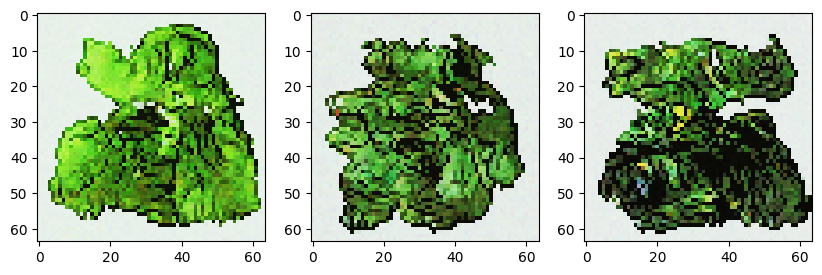

0.02199819:  72%|██████████████████████████████████████████████████████████████████████████████▍                              | 71999/100001 [1:44:01<39:47, 11.73it/s]

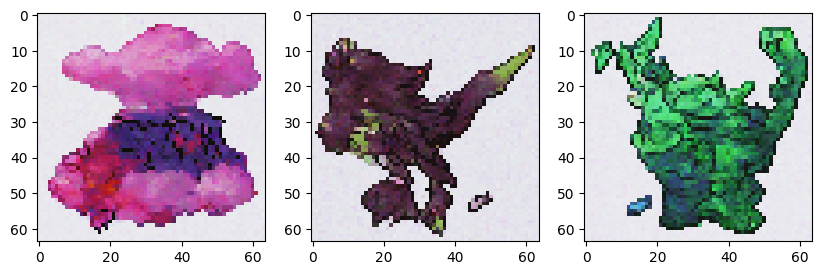

0.02350077:  73%|███████████████████████████████████████████████████████████████████████████████▌                             | 72999/100001 [1:45:28<38:22, 11.73it/s]

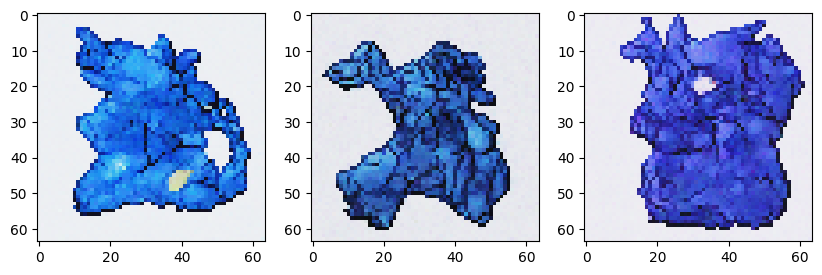

0.02615077:  74%|████████████████████████████████████████████████████████████████████████████████▋                            | 73999/100001 [1:46:54<36:57, 11.73it/s]

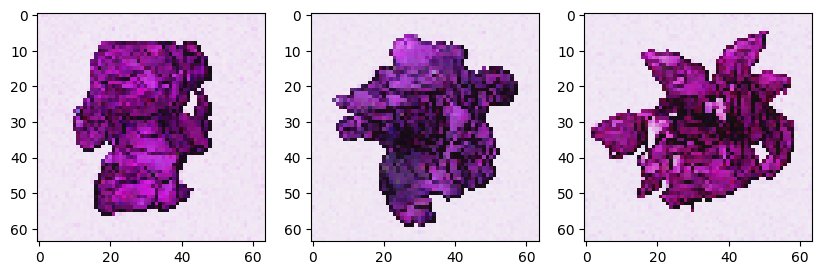

0.02134865:  75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 74999/100001 [1:48:21<35:32, 11.73it/s]

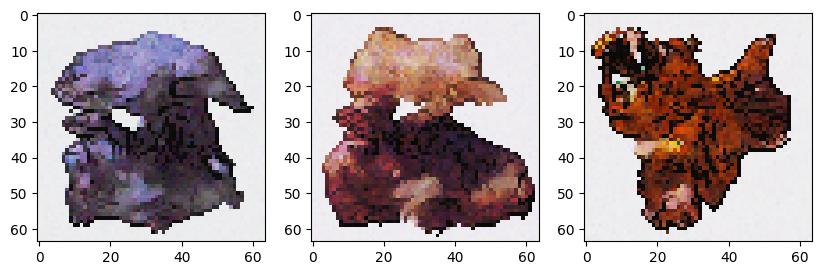

0.01360758:  76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 75999/100001 [1:49:48<34:03, 11.75it/s]

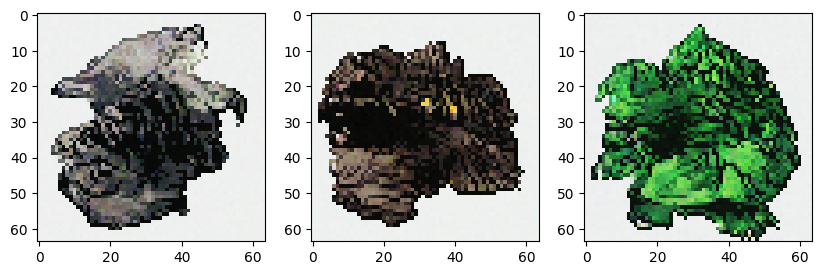

0.01565466:  77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 76999/100001 [1:51:15<32:42, 11.72it/s]

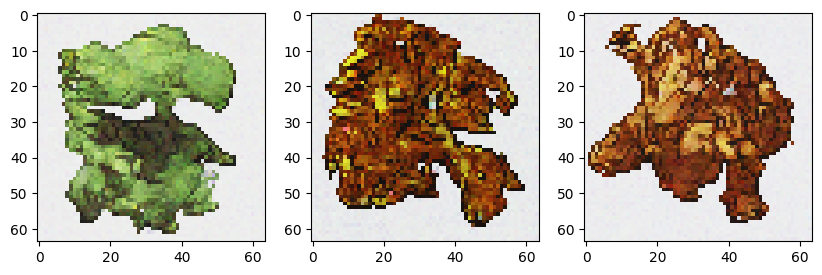

0.01405166:  78%|█████████████████████████████████████████████████████████████████████████████████████                        | 77999/100001 [1:52:41<31:16, 11.73it/s]

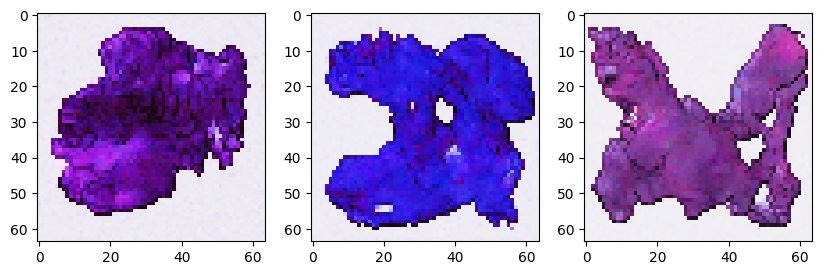

0.01093448:  79%|██████████████████████████████████████████████████████████████████████████████████████                       | 78999/100001 [1:54:08<29:51, 11.72it/s]

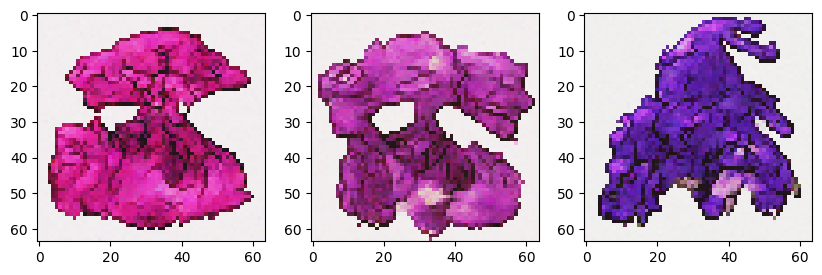

0.01658514:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 79999/100001 [1:55:35<28:25, 11.73it/s]

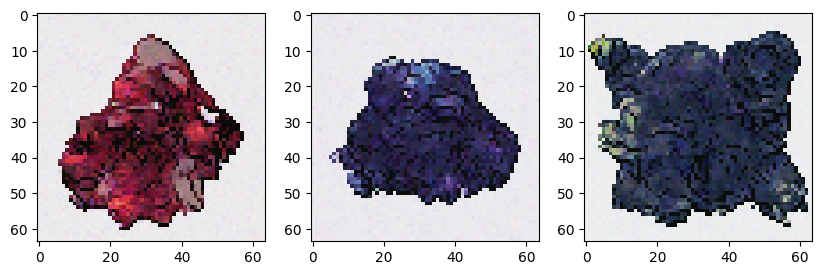

0.02644143:  81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 80999/100001 [1:57:01<26:59, 11.74it/s]

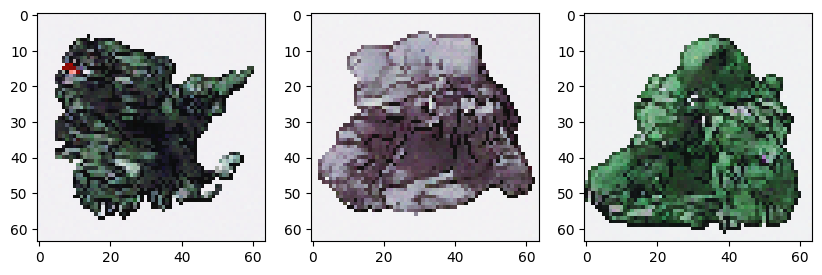

0.01207203:  82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 81999/100001 [1:58:28<25:36, 11.72it/s]

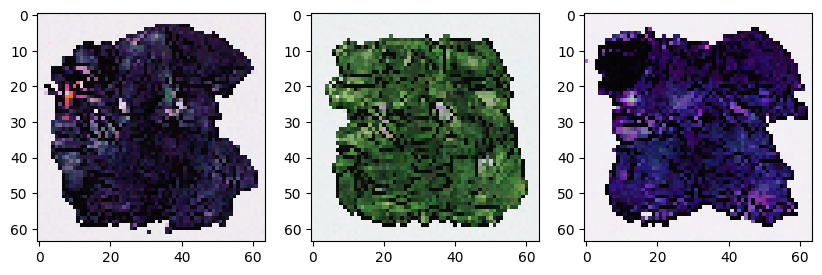

0.01587487:  83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 82999/100001 [1:59:55<24:10, 11.72it/s]

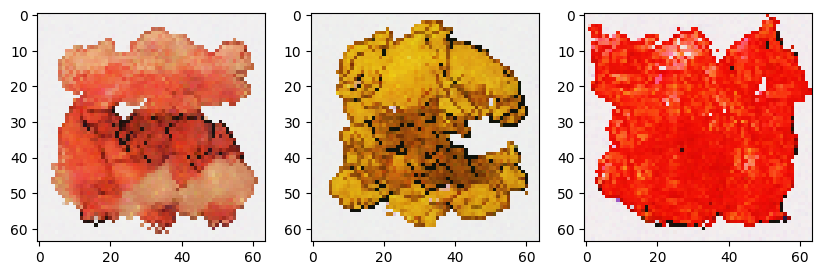

0.01693463:  84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 83999/100001 [2:01:22<22:42, 11.75it/s]

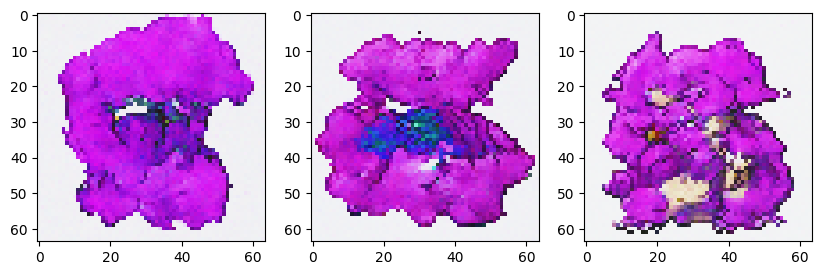

0.02401981:  85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 84999/100001 [2:02:48<21:18, 11.73it/s]

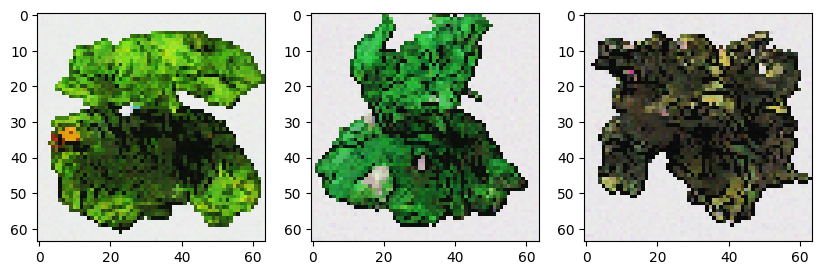

0.00606692:  86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 85999/100001 [2:04:15<19:53, 11.73it/s]

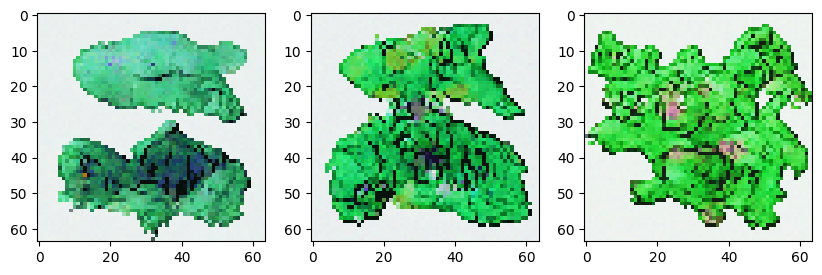

0.02023594:  87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 86999/100001 [2:05:42<18:27, 11.74it/s]

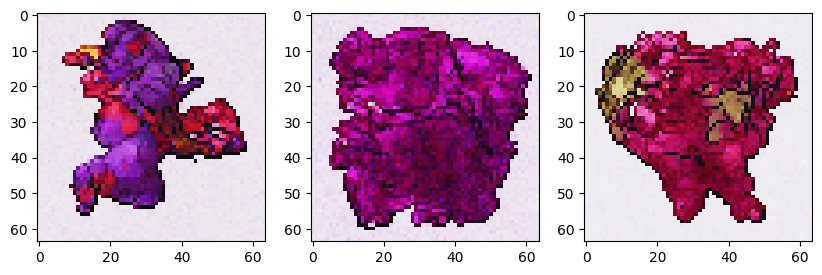

0.00967017:  88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 87999/100001 [2:07:09<17:02, 11.73it/s]

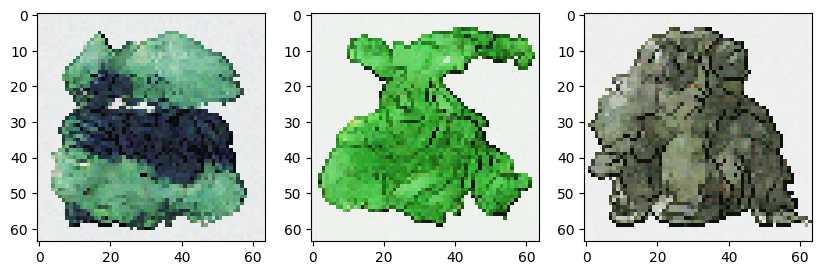

0.02144281:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 88999/100001 [2:08:35<15:38, 11.73it/s]

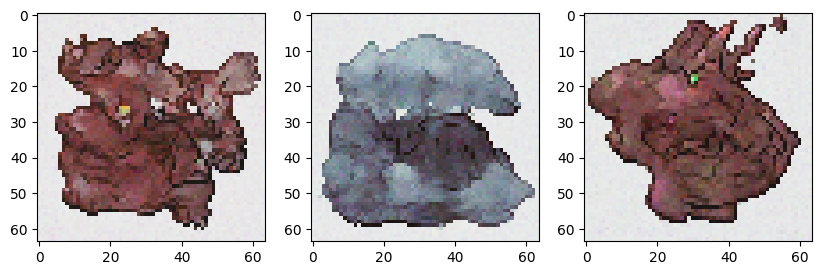

0.01912594:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 89999/100001 [2:10:02<14:13, 11.72it/s]

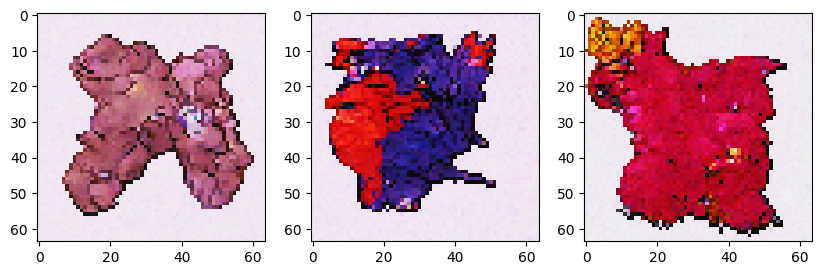

0.01338826:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 90999/100001 [2:11:29<12:47, 11.73it/s]

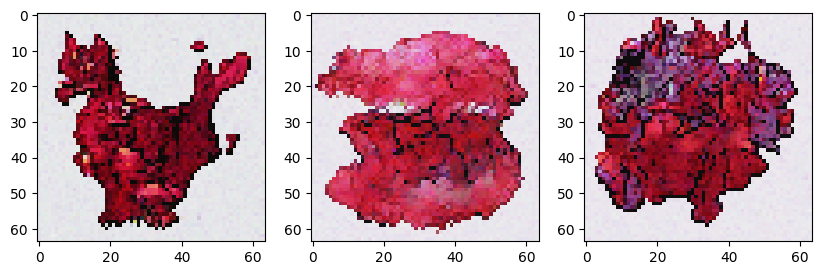

0.01128130:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 91999/100001 [2:12:56<11:22, 11.73it/s]

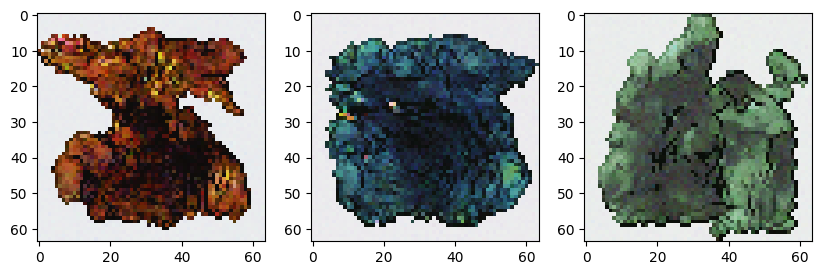

0.01644854:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 92999/100001 [2:14:22<09:56, 11.73it/s]

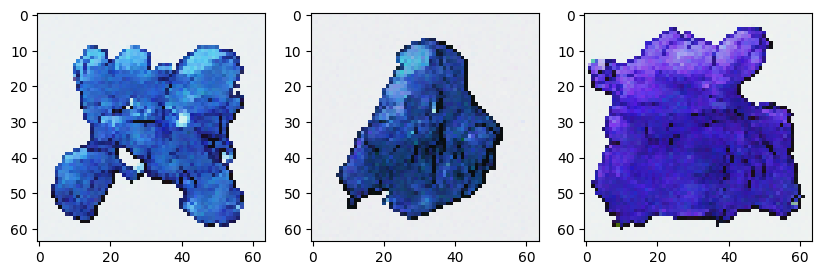

0.00969940:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 93999/100001 [2:15:49<08:31, 11.73it/s]

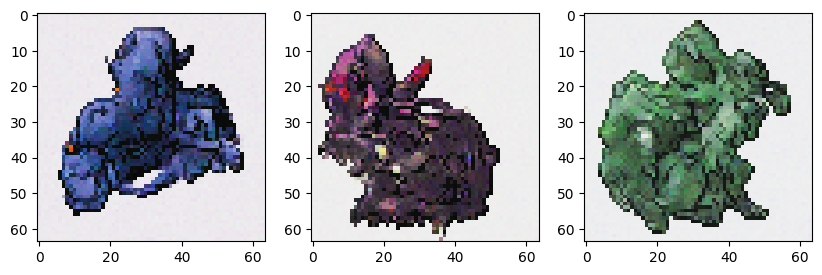

0.00495768:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 94999/100001 [2:17:16<07:06, 11.73it/s]

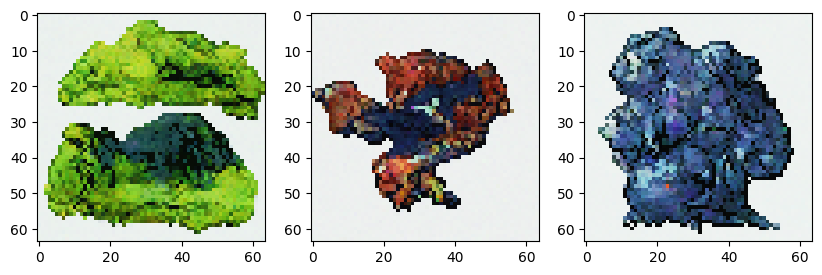

0.01692882:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 95999/100001 [2:18:42<05:40, 11.74it/s]

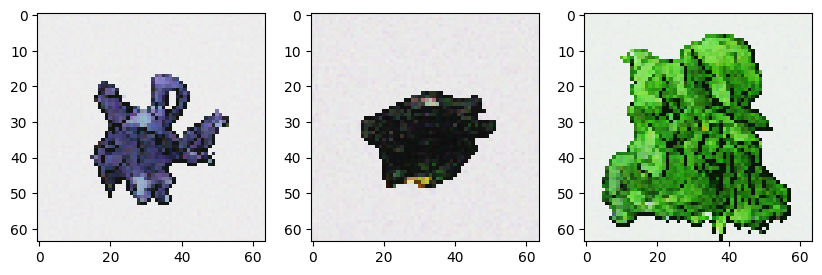

0.01076273:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 96999/100001 [2:20:09<04:16, 11.72it/s]

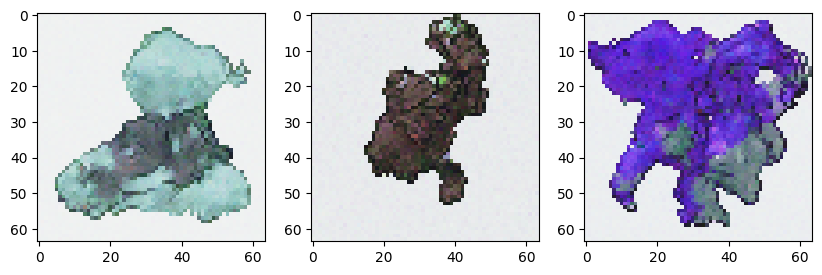

0.01555807:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 97999/100001 [2:21:36<02:50, 11.72it/s]

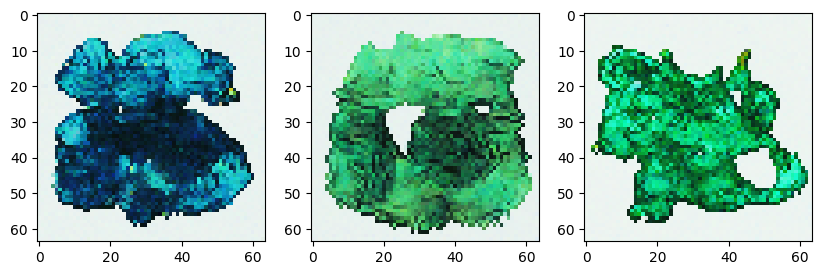

0.01674919:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 98999/100001 [2:23:03<01:25, 11.73it/s]

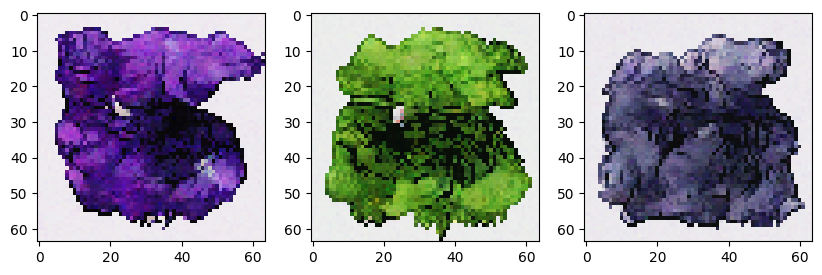

0.01810116: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 99999/100001 [2:24:29<00:00, 11.72it/s]

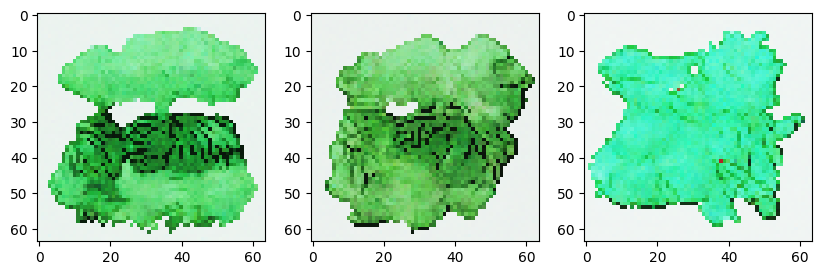

0.00876593: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100001/100001 [2:24:31<00:00, 11.53it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    h = height[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, h)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')